In [1]:
!git clone -q -b feature/demo https://github.com/avsthiago/deepbee-source.git
%cd deepbee-source/notebooks/

fatal: destination path 'deepbee-source' already exists and is not an empty directory.
/content/deepbee-source/notebooks


In [2]:
!pip install -q -r ../requirements.txt

In [3]:
# Download sample images
!gdown -q 17aa1xCnM0CsHjLrWzDmAJD852QdEa0T_ -O data/raw/
!unzip -q data/raw/sample-images.zip -d data/raw/
!rm data/raw/sample-images.zip !rm -rf data/raw/_*

replace data/raw/BEE_HOPE ZAVIAL 2016_09_20 BL1_Z DSC_3858.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Download the segmentation model
!gdown -q 17KyogWBf61lKfmIW1AVPj_0Hd-ngVX8A -O models/

In [6]:
# Download the classification model
!gdown -q 14HNikm69MhMflBtxYtzjZge2OOH8Y1vE -O models/

In [7]:
import numpy as np
import cv2
import sys
from keras.saving import load_model
import matplotlib.pyplot as plt
from utils.detection_on_segmentation import detect_cells_on_segmentation
from tensorflow.keras.applications.mobilenet import preprocess_input
from collections import Counter
from utils.classification import extract_cells_images, draw_circles_labels
%matplotlib inline

In [8]:
img = cv2.imread("data/raw/BEE_HOPE GIMONDE 2016_06_30 BL3_G DSC_2864.jpeg")

In [9]:
def convert_bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

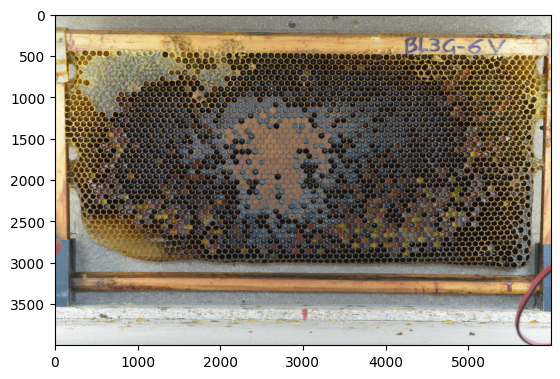

In [10]:
img_rgb = convert_bgr_to_rgb(img)
plt.imshow(img_rgb)
plt.show()

## Segment the frame and detect cells

In [11]:
seg_model = load_model("models/segmentation_model.keras")

In [12]:
cells, _ = detect_cells_on_segmentation(seg_model, img)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step


## Classify cells

In [29]:
cells_copy = np.copy(cells)
cells_images = extract_cells_images(img_rgb, cells_copy)

In [30]:
cells_images_preproc = preprocess_input(cells_images)

In [51]:
labels = ["Capped", "Eggs", "Honey", "Larves", "Nectar", "Other", "Pollen"]

In [31]:
classification_model = load_model("models/mobilenet_224.keras")

In [ ]:
predictions = None
batches = []
batch_size = 100

for i in range(0, len(cells_images_preproc), batch_size):
    batches.append(cells_images_preproc[i : i + batch_size])

# classify the images in batches
for batch in batches:
    output = classification_model.predict(batch)

    if predictions is None:
        predictions = np.copy(output)
    else:
        predictions = np.vstack((predictions, output))

predictions_class = np.argmax(predictions, axis=1)
cells_predictions = np.hstack((np.copy(cells), np.expand_dims(predictions_class, axis=0).T))

In [42]:
sum_predictions = Counter(predictions_class)
prediction_labels = [j + " " + str(sum_predictions[i]) for i, j in enumerate(labels)]

predicted_image = draw_circles_labels(img, prediction_labels, cells_predictions)

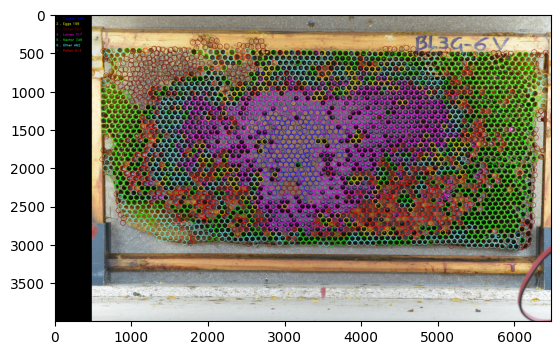

In [47]:
predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
plt.imshow(predicted_image_rgb)
plt.show()

In [45]:
cv2.imwrite("output.jpg", predicted_image)

True